In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math

In [101]:
# Parameters

dataset = 'tij_InVS15'
beta = 1
Delta_T = 200
k = 10
phi = 0.1

In [133]:
# Construct Graph

src, dst, ts = [], [], []
G = nx.MultiGraph()

with open(f'../data/{dataset}.txt', 'r') as f:
    for line in f:
        line = list(map(int, line.strip().split('\t')))
        src.append(line[0])
        dst.append(line[1])
        ts.append(line[2])

        G.add_node(line[0], is_infected=False, infected_at=math.inf)
        G.add_node(line[1], is_infected=False, infected_at=math.inf)

        G.add_edge(line[0], line[1], key=line[2], timestamp=line[2])

src, dst, ts = np.array(src), np.array(dst), np.array(ts) # ts is given sorted
print(G)

MultiGraph with 217 nodes and 78249 edges


In [79]:
a = np.array([src, dst, ts])
a = a.T
# np.any(np.all(np.unique(a, axis=1) == a, axis=1))
u, c = np.unique(a, return_counts=True, axis=0)
u[c > 1]

array([], shape=(0, 3), dtype=int64)

In [ ]:
# Calculate node influences

rng = np.random.RandomState(1)

node_influences = []

# for each node in the graph
for node in G.nodes:
    if not np.any(src == node):
        node_influences.append(0)
        continue
    t_0 = np.min(ts[src == node])

    G.nodes[node]['is_infected'] = True
    G.nodes[node]['infected_at'] = t_0

    # for every timestep in (t_0, t_0 + Delta_T)
    for t in range(t_0 + 1, t_0 + Delta_T):
        # if off bounds, continue
        if t not in ts:
            continue
        # for every node in the graph
        for n, nbrs in G.adjacency():
            # if the node is infected
            if G.nodes[n]['is_infected']:
                # get its neighbors at that timestamp
                for nbr, eattr in nbrs.items():
                    if t in eattr.keys() and G.nodes[n]['infected_at'] < t:
                        # infect them with probability b
                        if rng.uniform() <= beta:
                            # print(f"Marking {nbr} as infected at {t} since {n} was infected at {G.nodes[n]['infected_at']}")
                            G.nodes[nbr]['is_infected'] = True
                            G.nodes[nbr]['infected_at'] = t

    # node influence
    node_influences.append(len([n for n in G.nodes if G.nodes[n]['is_infected']]) / len(G.nodes))

    # reset graph
    for n in G.nodes:
        G.nodes[n]['is_infected'] = False

node_influences = np.array(node_influences)

In [ ]:
# Construct subgraphs and calculate subgraph-related metrics

####### labels #######
labels = [
    'Number of union of contacts in [t_0, t_0 + phi*Delta_T]',
    'Closeness Centrality',
    # 'Wiener Indices',
    'Betweenness Centrality',
    # 'Subgraph Centrality',
    'VoteRank',
    'Degree',
    'Degree Assortativity Coefficient',
    'Harmonic Centrality',
    'Local Reaching Centrality',
    # 'Eigenvector Centrality'
]

metrics = [[] for _ in labels]
for node in G.nodes:
    if not np.any(src == node) or not np.any(dst == node):
        for i in range(len(metrics)):
            metrics[i].append(0)
        continue
    # get the index of the first time that node appears
    start_src_idx = np.min(np.arange(len(src))[src == node])
    start_dst_idx = np.min(np.arange(len(src))[dst == node])
    start_idx = min(start_src_idx, start_dst_idx)
    # t_0 = ts[start_idx]

    subgraph = nx.MultiGraph()  # subgraph in (t_0, t_0 + Delta_T)
    i = start_idx
    j = ts[i]
    while i < len(src) and ts[i] < j + int(phi * Delta_T):
        subgraph.add_edge(src[i], dst[i], key=ts[i])
        i += 1

    ####### metrics #######
    metrics[0].append(len(nx.single_source_shortest_path(subgraph, node, cutoff=k)))
    metrics[1].append(nx.closeness_centrality(subgraph, node))
    # metrics[2].append(nx.wiener_index(subgraph))
    metrics[2].append(nx.betweenness_centrality(subgraph)[node])
    # metrics[3].append(nx.subgraph_centrality(subgraph)[node])
    metrics[3].append(np.argmax(nx.voterank(subgraph)))
    metrics[4].append(subgraph.degree[node])
    metrics[5].append(nx.degree_assortativity_coefficient(subgraph))
    metrics[6].append(nx.harmonic_centrality(subgraph)[node])
    metrics[7].append(nx.local_reaching_centrality(subgraph, node))
    # metrics[10].append(nx.eigenvector_centrality(subgraph)[node])

for i, m in enumerate(metrics):
    m = np.array(m)
    m = np.abs(m)
    ma = np.max(m[m != np.inf])
    m = m / ma # scale it to 0-1
    m[m == np.inf] = 1
    metrics[i] = m

In [129]:
# Calculate MSEs

y = node_influences
mse = []
for m in metrics:
    mse.append((np.sum(m - y)**2) / len(y))
list(zip(labels, mse))

[('Number of union of contacts in [t_0, t_0 + Delta_T]', 0.3315342767494575),
 ('Closeness Centrality', 1.2612737557049487),
 ('Betweenness Centrality', 3.611095498230826),
 ('VoteRank', 5.216615170418318),
 ('Degree', 0.5970555022145042),
 ('Degree Assortativity Coefficient', nan),
 ('Harmonic Centrality', 0.20862473892900457),
 ('Local Reaching Centrality', 0.7415859993024313)]

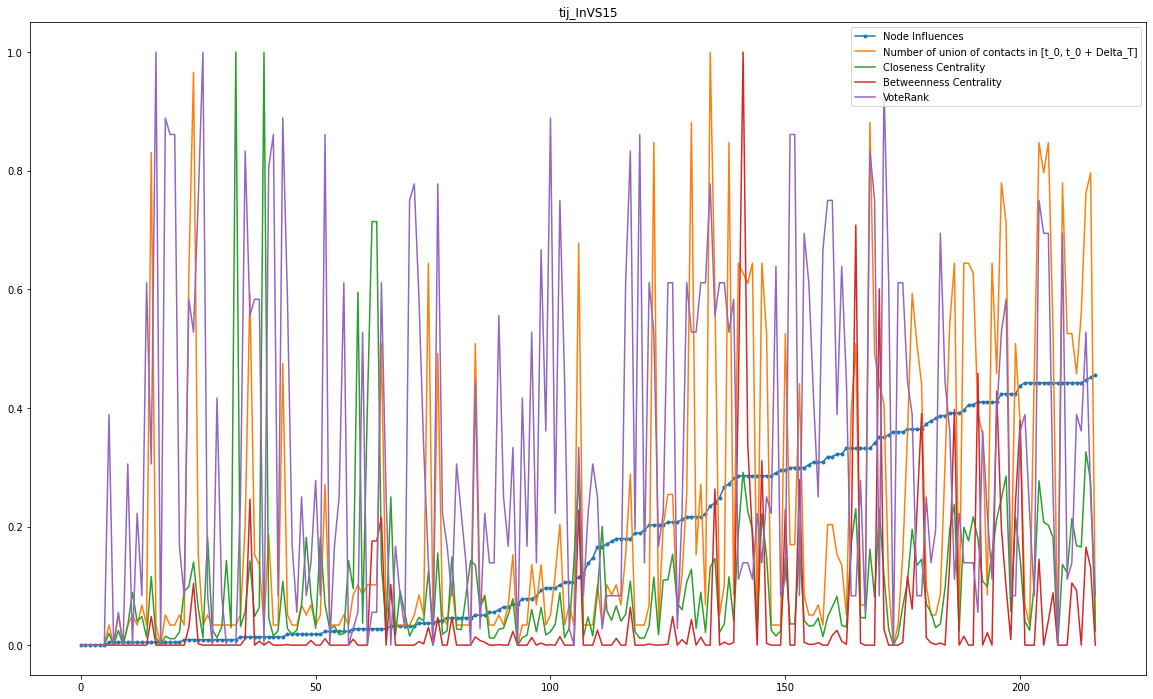

In [134]:
# Plot

# sort to compare cumulatively
sort = True

x = np.arange(len(node_influences))

plot_metrics = metrics.copy()

sort_idxs = np.argsort(node_influences)
y = node_influences[sort_idxs] if sort else node_influences
for i, m in enumerate(metrics):
    plot_metrics[i] = m[sort_idxs] if sort else m

fig, ax1 = plt.subplots(figsize=(20, 12))
ax1.plot(x, y, '.-', label='Node Influences')
for i, m in enumerate(plot_metrics[:4]):
    ax1.plot(x, m, label=labels[i])
plt.title(dataset)
plt.legend()
plt.savefig(f'{dataset}{"-cumulative" if sort else ""}.png')

Conclusions

Useful metrics that seem to model closely to the node influences, apart from Num. of union of contacts:

|dataset      | n_nodes | n_edges | beta |Delta_T|duration|k    |phi  |best metrics|
| ----------- |-------- | ------- | ---- | ----- | ------ | --- | --- | ---------- |
| ht09        |  113    |  20818  | 0.8  | 1000  | 27s    | 5   | 0.5 | Closeness Centrality, Degree Assortativity Coefficient     |
| infectious  |     410 |  17298  | 0.6  | 500   | 67s    | 5   | 0.5 | Eigenvalue Centrality does not converge, so removed. Betweeness/Subgraph centrality. |
| SFHH        |     403 | 70261   | 0.6  | 500   |  180s  | 5   | 0.5 | Eigen. not converging, removed. Num of union of contacts, Degree, Harmonic/Local-Reaching Centralities. |    
| tij_lnVS15  |   217   | 78249   | 0.6  | 500   |  21s   | 5   | 0.5 | Eigen. again not conv., removed. Betweeness/Subgraph centralities |


In [142]:
fit = np.polyfit(y, np.array([metrics[0], metrics[1]]).T, 1) #The use of 1 signifies a linear fit.
# line = np.poly1d(fit)
# len(np.array([metrics[0], metrics[1]]).T)
fit
np.poly(fit)

array([ 1.        ,  0.46275714, -0.07443504])